# Analysis of Kepler SNR

Starting from GTI-cleaned event lists, extract spectra from a number of regions, as listed in `kepler_pn_regions_detxy.reg`


In [117]:
import os
import subprocess
import sys
import glob
import logging

import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import mad_std
from astropy.convolution import convolve, Box1DKernel
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization import simple_norm

from regions import DS9Parser
from regions import read_ds9

from lmfit.models import GaussianModel, PolynomialModel

%matplotlib inline
import matplotlib.pylab as plt

In [2]:
def run_command(command,verbose=True):
    #
    # Execute a shell command with the stdout and stderr being redirected to a log file 
    #
    try:
        result = subprocess.run(command, shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
        retcode=result.returncode
        if retcode < 0:
            if (verbose):
                print(f"Execution of {command} was terminated by signal", -retcode, file=sys.stderr)
            logging.warning("Execution of {} was terminated by signal: {} \n {}".format(command,-retcode,result.stdout.decode()))
        else:
            if (verbose):
                print(f"Execution of {command} returned", retcode, file=sys.stderr)
            logging.info("Execution of {} returned {}, \n {}".format(command,retcode,result.stdout.decode()))
    except OSError as e:
        print(f"Execution of {command} failed:", e, file=sys.stderr)
        logging.error("Execution of {} failed: {}".format(command,e))
    return retcode

In [115]:
def fit_xmm_line(xin,yin, minMax=(7.0,9.0),line_c=6.4):
    #
    # PURPOSE:
    #   Fit a single Gaussian line, the total model is a polynomial(2) + a Gaussian line.
    #
    # INPUTS:
    #   xin is the energy channel (in keV)
    #   yin is the counts
    #   line_c is the initial energy of the line (in keV)
    #   minMax is a tuple (in keV) of the energy limits to consider for the model and the fit
    #
    # OUTPUTS:
    #  a tuple of the full fit output class and the results line in ascii.
    #
    # NOTES:
    #
    #
    m1 = xin >= minMax[0]
    m2 = xin <= minMax[1]
    xw = xin[m1*m2]
    yw = yin[m1*m2]
    i1max = np.argmax(yw)
    y1max = yw[i1max]
    #x1max = xw[i1max]
    #
    poly_mod = PolynomialModel(1,prefix='poly_')
    pars = poly_mod.guess(yw, x=xw)
    #
    gauss1  = GaussianModel(prefix='g1_')
    pars.update( gauss1.make_params())
    pars['g1_center'].set(line_c,min=line_c-0.2,max=line_c+0.1)
    #pars['g1_sigma'].set(0.1,min=0.04,max=0.250)
    pars['g1_sigma'].set(0.1)
    pars['g1_amplitude'].set(y1max)
    #
    mod = poly_mod + gauss1
    #init = mod.eval(pars, x=x)
    out = mod.fit(yw, pars, x=xw)
    #
    cen = out.params['g1_center'].value
    cen_err = out.params['g1_center'].stderr
    fwhm = out.params['g1_fwhm'].value
    fwhm_err = out.params['g1_fwhm'].stderr
    #peak = out.params['g1_amplitude'].value/expo1
    #peak_err = out.params['g1_amplitude'].stderr/expo1
    chi2 = out.chisqr
    df = len(xw)
    try:
        results  = f"{cen:.4f},{cen_err:.4f},{fwhm:.5f},{fwhm_err:.5f},{chi2:.3f},{df}"
    except:
        results = None
    #
    return (out,results)


## Setting up XMM-SAS

For some reason, running the ipython magic command `!. /home/xcaldata/setsas_161.sh`, does not propagate to the session, i.e. although it prints out that SAS is set up, it is not available after the execution of the shell command. So, I have to do it manually, by setting some environment variables.

The last line in the next cell, `!sasversion` should work.

In [3]:
#
# set up XMM-SAS
#
# the current one is 18.0 ==> /home/xcaldata/setsas_180.sh
# tests with XMM-SAS 16.1 for the arfgen
#!. /home/xcaldata/setsas_161.sh
#
sas_dir = "/sas/Linux/RHEL_6.9Workstation/64/sas18_0_0"
#sas_dir = "/sas/Linux/RHEL_6.9Workstation/64/sas16_1_0"
os.environ["SAS_DIR"]= sas_dir
os.environ["SAS_PATH"]=os.environ["SAS_DIR"]
os.environ["SAS_VERBOSITY"]="4"
os.environ["SAS_SUPPRESS_WARNING"]="1"
path = os.environ["PATH"]
os.environ["PATH"] = f"{sas_dir}/bin:{sas_dir}/binextra:{path}"
ld_path = os.environ["LD_LIBRARY_PATH"]
lib_path = f"{sas_dir}/lib:{sas_dir}/libextra:{sas_dir}/libsys:{ld_path}"
os.environ["LD_LIBRARY_PATH"] = lib_path
#
# check
#print ("PATH = ",os.environ["PATH"])
#print ("LF_LIBRARY_PATH = ",os.environ["LD_LIBRARY_PATH"])
#for ikey in os.environ.keys():
#    if ('SAS' in ikey):
#        print (ikey," = ",os.environ[ikey])
!sasversion

sasversion:- Executing (routine): sasversion  -w 1 -V 4
sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] started:  2019-07-10T08:20:32.000
sasversion:- XMM-Newton SAS release and build information:

SAS release: xmmsas_20190531_1155-18.0.0
Compiled on: Sun Jun  2 14:11:08 CEST 2019
Compiled by: sasbuild@sasbld01n.net4.lan
Platform   : RHEL6.8 64

SAS-related environment variables that are set:

SAS_DIR = /sas/Linux/RHEL_6.9Workstation/64/sas18_0_0
SAS_PATH = /sas/Linux/RHEL_6.9Workstation/64/sas18_0_0
SAS_CCFPATH = /xdata/ccf/pub

sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] ended:    2019-07-10T08:20:32.000


## Processing of a target

Next cell sets up the target name, the XMM `OBS_ID` and the different paths. I usually keep the following structure in the `root_dir`:
```
<target>
   <OBS_ID 1>
       <proc>
   <OBS_ID 2>
       <proc>
   ...
```
where in folders `<OBS_ID>` I keep the ODF files and the CCF file. While in `<proc>` I keep the processing products, like event lists, images etc. The spectral extraction regions are also kept in `<proc>` folder.

For processing with different versions of SAS or calibration, I use different names for the `<proc>` folders.

In [4]:
#
# set up the paths, the target and the OBS_ID
#
root_dir = "/xdata/xcaldata/XMM/IVAN/PN_LW/sources"
#root_dir = "/lhome/ivaltchanov/XMM-clusters"
target="Kepler"
obsid="0084100101"
#target="CasA_S"
#obsid="0110010201"
#target="PuppisA"
#obsid="0150150301"
#target="A2029"
#obsid="0551780301"
#target="A3571"
#obsid="0086950201"
#target="Coma"
#obsid="0300530101"

# the output processing is in folder pps
pps="proc_18"
odf_dir = f"{root_dir}/{target}/{obsid}"
#
if (not os.path.isdir(odf_dir)):
    print (f"{odf_dir} does not exist. Cannot continue.")
    raise FileNotFoundError
else:
    print (f"Found ODF folder: {odf_dir}.")
#
pps_dir = f"{root_dir}/{target}/{obsid}/{pps}"
if (not os.path.isdir(pps_dir)):
    print (f"{pps_dir} does not exist. Cannot continue.")
    raise FileNotFoundError
else:
    print (f"Will use {pps_dir} for the event lists and the output products.")
#
ccf_file = f"{pps_dir}/ccf.cif"
if (not os.path.isfile(ccf_file)):
    print (f"CCF file {ccf_file} not found. Cannot continue.")
    raise FileNotFoundError
else:
    print (f"Will use {ccf_file} CCF file.")

os.environ['SAS_ODF'] = odf_dir
os.environ['SAS_CCFPATH'] = '/ccf/pub'
os.environ['SAS_CCF'] = f"{pps_dir}/ccf.cif"
#
# logging to file
#
logfile_name = f'{pps_dir}/{target}_{obsid}_{pps}_specext.log'
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s %(message)s',
                    filename=logfile_name,
                    filemode='w')
os.chdir(pps_dir)

Found ODF folder: /xdata/xcaldata/XMM/IVAN/PN_LW/sources/Kepler/0084100101.
Will use /xdata/xcaldata/XMM/IVAN/PN_LW/sources/Kepler/0084100101/proc_18 for the event lists and the output products.
Will use /xdata/xcaldata/XMM/IVAN/PN_LW/sources/Kepler/0084100101/proc_18/ccf.cif CCF file.


In [5]:
#
# check for consistency the SAS version
#
status = run_command('sasversion')
if (status != 0):
    print ('XMM-SAS is not available. Cannot continue.')
    raise Exception
else:
    print ("Found XMM-SAS.")
#

Found XMM-SAS.


Execution of sasversion returned 0


### Parsing the region file in detector X,Y coordinates

The regions are listed in `kepler_pn_regions_detxy.reg`


In [12]:
src_file = 'kepler_pn_regions_detxy.reg'
if (not os.path.isfile(src_file)):
    print (f"Cannot find region file {src_file}")
    raise FileNotFoundError
#
with open(src_file,'r') as reg:
    lines = reg.readlines()
regs = {}
for xline in lines:
    if ('circle' in xline):
        q = xline.split()
        i1 = q[2].find('{')
        i2 = q[2].find('}')
        sid = q[2][i1+1:i2]
        regs[sid] = q[0]
#
for ir in regs.keys():
    print (ir,regs[ir])

s1 circle(23651.592,25263.554,600)
s2 circle(24863.174,25606.547,600)
s3 circle(26086.552,25366.399,600)
s4 circle(23240.125,24029.057,600)
s5 circle(24531.726,23937.508,600)
s6 circle(25766.354,24086.199,600)
s8 circle(25480.58,22474.39,600)
s7 circle(23742.924,22371.372,600)


## Plot the image and the regions

The plotting needs the region file in sky coordinates. TODO: find a way to use directly the physical (detector) X,Y coordinates.

We also zoom on the target, centred on `RA_OBJ, DEC_OBJ` with image size 5x5 arcmin. The regions are labeled.

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


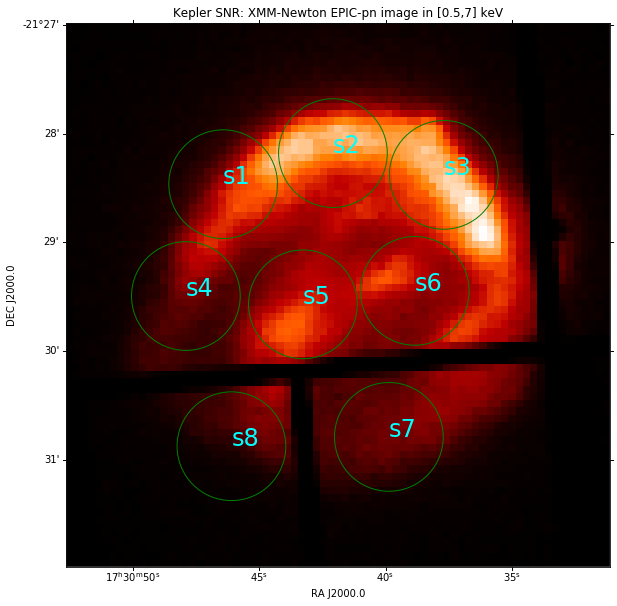

In [114]:
qregs = read_ds9('kepler_pn_regions_radec.reg')
#print (qregs)
hdu = fits.open("pn_image_500_7000.fits")
wcs = WCS(hdu[0])
#
zoomSize = u.Quantity((5,5), u.arcmin)
c = SkyCoord(hdu[0].header['RA_OBJ'], hdu[0].header['DEC_OBJ'], frame='icrs',unit='deg')
cutout = Cutout2D(hdu[0].data, c, zoomSize, wcs=wcs)
# noramlize
norm = simple_norm(cutout.data, 'asinh')
#
fig = plt.figure(figsize=(10,10))
#ax = fig.subplot(projection=cutout.wcs)
ax = plt.gca(projection=cutout.wcs)
ax.imshow(cutout.data, cmap='gist_heat',origin='lower',norm=norm)
ax.set_title("Kepler SNR: XMM-Newton EPIC-pn image in [0.5,7] keV")
ax.set_xlabel('RA J2000.0')
ax.set_ylabel('DEC J2000.0')

for i, qr in enumerate(qregs):
    qx = qr.to_pixel(cutout.wcs)
    qx.plot(ax=ax)
    ax.text(qx.center.x,qx.center.y,f's{i+1}',color='cyan',fontsize=24)

## Extract PN source spectra in user provided regions

Will use the region labels


In [14]:
#
inst = 'pn'
evlist = f'{inst}_evlist_clean.fits'
for ir in regs.keys():
    spec_name = f'{target}_{obsid}_{inst}_{ir}.fits'
    print (f"Extracting {ir} region in {spec_name}")
    #
    if ('pn' in inst):
        spec_chan_max = 20479
        expr1 = "(FLAG==0) && (PATTERN<=4)"
    else:
        spec_chan_max = 11999
        expr1 = "#XMMEA_EM && (PATTERN<=12)"
    #
    ev_command = f"evselect table={evlist} withspectrumset=yes spectrumset={spec_name}" +  \
    f" energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax={spec_chan_max}" +  \
    f" expression='{expr1} && ((X,Y) IN {regs[ir]})'"
    status = run_command(ev_command)
    if (status != 0):
        raise Exception
    #
    # Now backscale the source spectrum
    #
    print ("*** Backscale the source spectrum")
    xcommand = f"backscale spectrumset={spec_name} badpixlocation={evlist}"
    status = run_command(xcommand)
    if (status != 0):
        raise Exception
print ("Spectral extraction done")

Extracting s1 region in Kepler_0084100101_pn_s1.fits


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=Kepler_0084100101_pn_s1.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(23651.592,25263.554,600))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=Kepler_0084100101_pn_s1.fits badpixlocation=pn_evlist_clean.fits returned 0


Extracting s2 region in Kepler_0084100101_pn_s2.fits


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=Kepler_0084100101_pn_s2.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(24863.174,25606.547,600))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=Kepler_0084100101_pn_s2.fits badpixlocation=pn_evlist_clean.fits returned 0


Extracting s3 region in Kepler_0084100101_pn_s3.fits


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=Kepler_0084100101_pn_s3.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(26086.552,25366.399,600))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=Kepler_0084100101_pn_s3.fits badpixlocation=pn_evlist_clean.fits returned 0


Extracting s4 region in Kepler_0084100101_pn_s4.fits


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=Kepler_0084100101_pn_s4.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(23240.125,24029.057,600))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=Kepler_0084100101_pn_s4.fits badpixlocation=pn_evlist_clean.fits returned 0


Extracting s5 region in Kepler_0084100101_pn_s5.fits


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=Kepler_0084100101_pn_s5.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(24531.726,23937.508,600))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=Kepler_0084100101_pn_s5.fits badpixlocation=pn_evlist_clean.fits returned 0


Extracting s6 region in Kepler_0084100101_pn_s6.fits


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=Kepler_0084100101_pn_s6.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(25766.354,24086.199,600))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=Kepler_0084100101_pn_s6.fits badpixlocation=pn_evlist_clean.fits returned 0


Extracting s8 region in Kepler_0084100101_pn_s8.fits


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=Kepler_0084100101_pn_s8.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(25480.58,22474.39,600))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=Kepler_0084100101_pn_s8.fits badpixlocation=pn_evlist_clean.fits returned 0


Extracting s7 region in Kepler_0084100101_pn_s7.fits


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=Kepler_0084100101_pn_s7.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(23742.924,22371.372,600))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=Kepler_0084100101_pn_s7.fits badpixlocation=pn_evlist_clean.fits returned 0


## Fitting the Fe K$\alpha$ line section

Fit the line with a simple model using a utility function `fit_xmm_line`, plot the results and save them as a table to a CSV file.

s1,6.4377,0.0037,0.22641,0.00896,1103.690,601
s2,6.4424,0.0023,0.23395,0.00550,2224.172,601
s3,6.4524,0.0024,0.23657,0.00579,1967.794,601
s4,6.4382,0.0043,0.21229,0.01032,610.802,601
s5,6.3967,0.0028,0.23845,0.00683,1135.842,601
s6,6.4310,0.0051,0.31164,0.01268,774.846,601
s8,6.4665,0.0040,0.21232,0.00970,493.955,601
s7,6.4670,0.0141,0.20876,0.03425,524.170,601


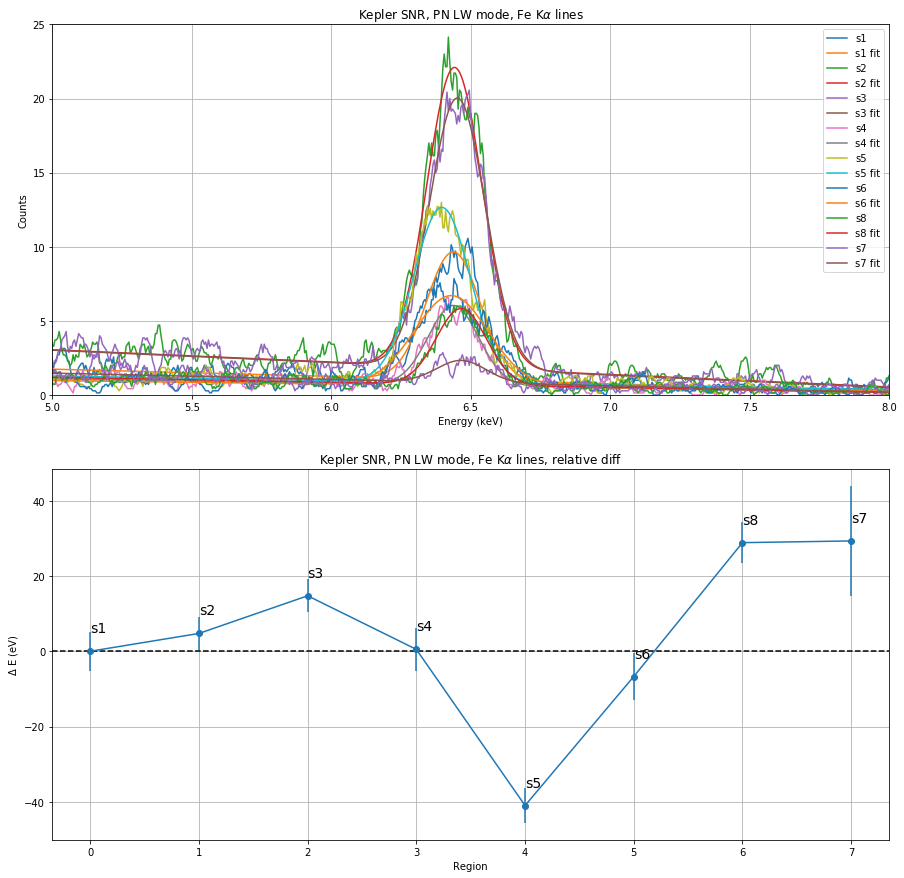

In [118]:
os.chdir(pps_dir)
#
# fit results will be saved to this file
outfile = 'Kepler_FeKa_fit_results.csv'
fout = open(outfile,'w')
print ("region,line,line_err,fwhm,fwhm_err,chi2,df",file=fout)
#
# plotting and fitting
#
fig = plt.figure(figsize=(15,15))
ax = fig.subplots(2,1)

line = []
line_err = []
xlab = []
for ir in regs.keys():
    spec_name = f'{target}_{obsid}_{inst}_{ir}.fits'
    hdu = fits.open(spec_name)
    qrev = hdu[0].header['REVOLUT']
    qsubmode = hdu[0].header['SUBMODE']
    qfilt = hdu[0].header['FILTER']
    #plot_title = f"Target: {target}, {qrev}_{obsid}, {qsubmode}, {qfilt}"
    #
    spec = hdu['SPECTRUM']
    binsize = spec.header['SPECDELT']
    x = spec.data['CHANNEL']*binsize/1000.0
    y = spec.data['COUNTS']
    ysm = convolve(y, Box1DKernel(7))
    # now fitting
    #
    fit_out,fit_res = fit_xmm_line(x,y,minMax=(5.0,8.0),line_c=6.48)
    yfitted = fit_out.eval(x=x)
    print (f"{ir},{fit_res}")
    print (f"{ir},{fit_res}",file=fout)
    line.append(fit_out.params['g1_center'].value)
    line_err.append(fit_out.params['g1_center'].stderr)
    xlab.append(ir)
    #
    ax[0].plot(x,ysm,label=f'{ir}')
    ax[0].plot(x,yfitted,label=f'{ir} fit')
    #ax.loglog(x,y,label=f'{ir}')
    #ax.step(a[1][1:],a[0],color='red')
    #ax.step(x,y,color='red')
#
line = np.asarray(line)
line_err = np.asarray(line_err)
#
xlims  = (5, 8.0)
ax[0].set_xlim(xlims)
ax[0].set_ylim([0,25.0])
#ax.set_xlim([4.0,8.0])
#ax.set_ylim((1.0e-2,))
ax[0].set_xlabel("Energy (keV)")
ax[0].set_ylabel("Counts")
#ax.set_title(plot_title)
ax[0].grid()
ax[0].legend()
ax[0].set_title(r"Kepler SNR, PN LW mode, Fe K$\alpha$ lines")
#
# second plot on the relative line energy offset
#
# reference will be the first regions
delta = (line-line[0])*1000.0 # in eV
delta_err = np.sqrt(line_err*line_err + line_err[0]*line_err[0])*1000.0 # in eV
#
ax[1].errorbar(np.arange(len(line)),delta,yerr=delta_err,fmt='o',linestyle='solid')
ax[1].axhline(0.0,color='black',linestyle='dashed')
#
for i, ir in enumerate(regs.keys()):
    ax[1].annotate(ir, (i, delta[i]+5),fontsize=14)
ax[1].grid()
ax[1].set_xlabel("Region")
ax[1].set_ylabel(r"$\Delta$ E (eV)")
ax[1].set_title(r"Kepler SNR, PN LW mode, Fe K$\alpha$ lines, relative diff")
plt.savefig(f"{pps_dir}/Kepler_FeKa_fit_results.png",dpi=100)
plt.show()
plt.close();
fout.close()

In [119]:
print ("*** All done.")
logging.info ("*** All done.")

*** All done.


In [122]:
s = SkyCoord(ra='17:30:42.00',dec='-21:29:30.0',unit=(u.hourangle,u.deg))

In [127]:
s.dec.deg

-21.491666666666667